In [1]:
import tensorflow as tf
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Create environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0] # 4 values: position,velocity, angle, angular velocity
action_size = env.action_space.n # 2 actions: move left or right

In [4]:
# Build a smaller model
model = tf.keras.Sequential([
 tf.keras.layers.Dense(12, input_dim=state_size,
activation='relu'),
 tf.keras.layers.Dense(action_size, activation='linear')
])
model.compile(loss='mse',
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86 (344.00 B)

 Trainable params: 86 (344.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Training parameters - REDUCED FOR SPEED
epsilon = 1.0 # Exploration rate
epsilon_decay = 0.9 # Faster decay
epsilon_min = 0.1
gamma = 0.95 # Discount factor
memory = []
batch_size = 16 # Smaller batch
episodes = 10 # Fewer episodes

# Track scores for plotting
scores = []

Episode: 1/10, Score: 18.0, Epsilon:0.90
Episode: 2/10, Score: 26.0, Epsilon:0.81
Episode: 3/10, Score: 17.0, Epsilon:0.73
Episode: 4/10, Score: 46.0, Epsilon:0.66
Episode: 5/10, Score: 96.0, Epsilon:0.59
Episode: 6/10, Score: 25.0, Epsilon:0.53
Episode: 7/10, Score: 12.0, Epsilon:0.48
Episode: 8/10, Score: 16.0, Epsilon:0.43
Episode: 9/10, Score: 16.0, Epsilon:0.39
Episode: 10/10, Score: 15.0, Epsilon:0.35


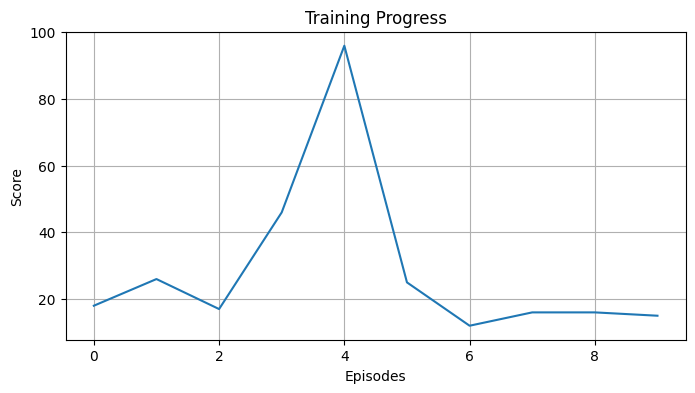

In [6]:
# Training loop
for episode in range(episodes):
  # Reset environment
  state, _ = env.reset()
  state = np.reshape(state, [1, state_size])
  done = False
  score = 0
  # Limit steps per episode for speed
  max_steps = 200

  for step in range(max_steps):
    # Choose action: explore or exploit
    if np.random.rand() <= epsilon:
      action = env.action_space.sample() # Explore
    else:
      action_values = model.predict(state, verbose=0)
      action = np.argmax(action_values[0]) # Exploit
    # Take action
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = np.reshape(next_state, [1, state_size])
    score += reward

    # Store experience
    memory.append((state, action, reward, next_state, done))
    state = next_state

    # Train model - only train every 4 steps for speed
    if len(memory) > batch_size and step % 4 == 0:
      # Sample random batch from memory
      batch = np.random.choice(len(memory), batch_size,replace=False)
      for i in batch:
        s, a, r, next_s, d = memory[i]
        # Q-learning formula
        target = r
        if not d:
          target = r + gamma * np.amax(model.predict(next_s,verbose=0)[0])
        target_f = model.predict(s, verbose=0)
        target_f[0][a] = target
        # Train network with a single sample
        model.fit(s, target_f, epochs=1, verbose=0)
    if done:
      break

  # Reduce exploration faster
  epsilon = max(epsilon_min, epsilon * epsilon_decay)
  scores.append(score)
  print(f"Episode: {episode+1}/{episodes}, Score: {score}, Epsilon:{epsilon:.2f}")
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(scores)
plt.title('Training Progress')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [7]:
# Quick test of trained model
print("\nTesting trained model...")
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
done = False
score = 0
for _ in range(200): # Limit test steps
  action_values = model.predict(state, verbose=0)
  action = np.argmax(action_values[0])
  next_state, reward, terminated, truncated, _ = env.step(action)
  done = terminated or truncated
  state = np.reshape(next_state, [1, state_size])
  score += reward
  if done:
    break

print(f"Test score: {score}")
env.close()


Testing trained model...
Test score: 13.0
